In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from read_db.CH import Getch

sns.set(font_scale=1.2)

ads - пользователь пришел через платный трафик  
organic - пользователь пришел через органические каналы  

Задача — проанализировать и сравнить Retention этих двух групп пользователей.  
Отличается ли характер использования приложения у этих групп пользователей.   

In [238]:
ads = Getch('''select date,start_date, count(user_id) as activ_users 
               from
                (select 
                    user_id, 
                    min(toDate(time)) as start_date
                from simulator_20220620.feed_actions 
                where source = 'ads'
                group by user_id
                having start_date >= today() - 20
                ) t1

                join

                (select 
                    distinct user_id, 
                    toDate(time) as date 
                from simulator_20220620.feed_actions
                ) t2

                using user_id

                group by date, start_date
                ''').df

In [239]:
organic = Getch('''select date,start_date, count(user_id) as activ_users 
                from
                (select 
                    user_id, 
                    min(toDate(time)) as start_date
                from simulator_20220620.feed_actions 
                where source = 'organic'
                group by user_id
                having start_date >= today() - 20
                ) t1

                join

                (select 
                    distinct user_id, 
                    toDate(time) as date 
                from simulator_20220620.feed_actions
                ) t2

                using user_id

                group by date, start_date
                ''').df

In [241]:
ads.head()

,date,start_date,activ_users
0,2022-06-22,2022-06-12,248
1,2022-06-15,2022-06-14,115
2,2022-06-28,2022-06-18,235
3,2022-06-25,2022-06-14,61
4,2022-06-25,2022-06-22,295


In [158]:
def creat_columns(df):
    df['max_value'] = df.groupby('start_date')['activ_users'].transform('max')
    df['prc'] = df['activ_users'] / df['max_value']
    return df

In [159]:
def pivot_table_retention(df):
    return df.pivot_table(index='start_date', columns='date', values='prc', aggfunc='mean')

In [160]:
retention_ads = pivot_table_retention(creat_columns(ads))
retention_organic = pivot_table_retention(creat_columns(organic))

In [194]:
def table_heatmap(df):    
    plt.figure(figsize = (14,10))
    ax = sns.heatmap(df, annot=True, cbar=False, annot_kws={"size":8}, fmt='.0%')
    ax.set_yticklabels([i.strftime("%Y-%m-%d") for i in df.index], rotation=0)
    ax.set_xticklabels([i.strftime("%Y-%m-%d") for i in df.index], rotation=45)
    plt.show()

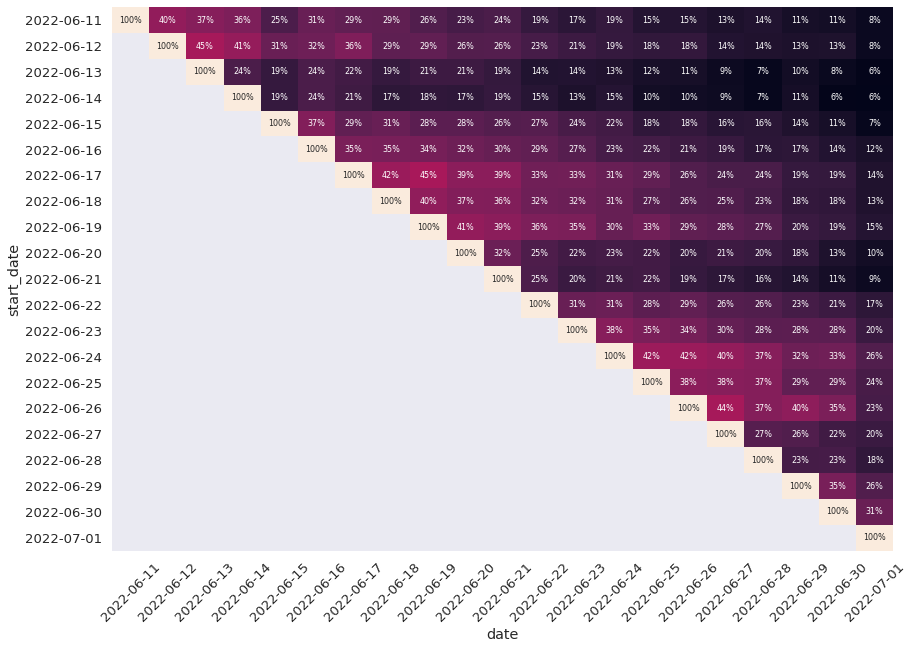

In [195]:
table_heatmap(retention_ads)

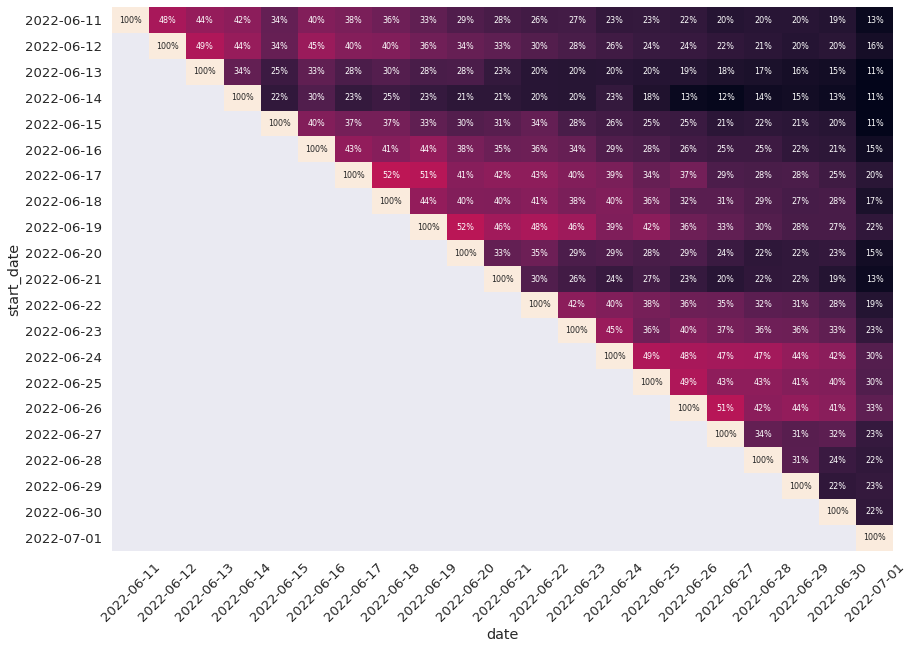

In [196]:
table_heatmap(retention_organic)

На тепловой карте видно, что retention organic более устойчив, чем retention ads  
Для еще большей наглядности сравним retention этих групп в динамике  

In [231]:
cohort = Getch('''select date, count(user_id) as user, source
    from
    (select 
        distinct user_id, 
        source,
        toDate(time) as date
    from simulator_20220620.feed_actions
    where user_id in 
        (select distinct user_id 
        from 
            (select 
                user_id, 
                min(toDate(time)) as start_date
            from simulator_20220620.feed_actions 
            group by user_id
            having start_date = today() - 30)) )
    group by date, source
''').df

In [235]:
cohort.head()

,date,user,source
0,2022-06-04,314,ads
1,2022-06-24,136,organic
2,2022-06-26,138,organic
3,2022-06-02,378,ads
4,2022-06-07,263,ads


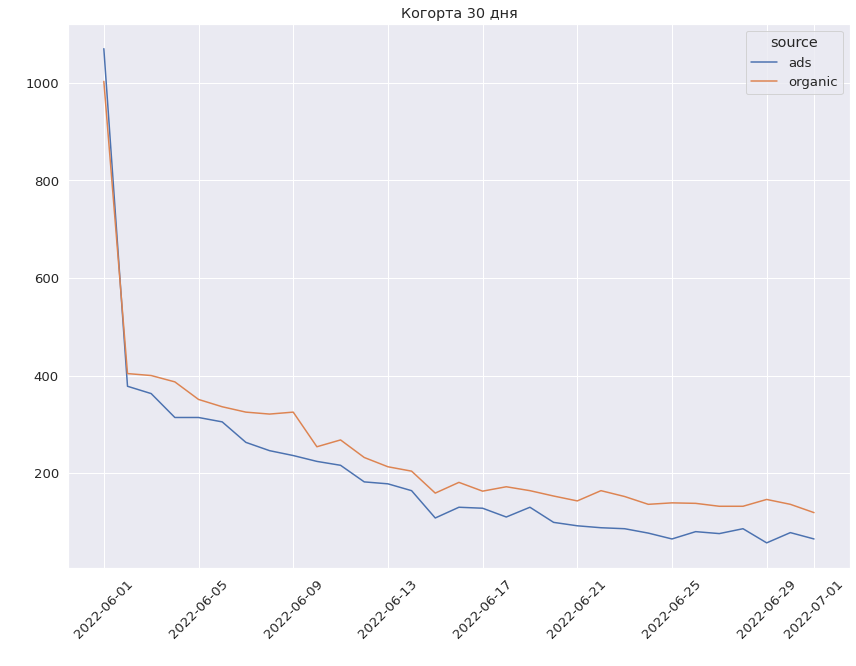

In [234]:
plt.figure(figsize = (14,10))
sns.lineplot(data=cohort, x="date", y="user", hue="source").set(title='Когорта 30 дня', xlabel=' ', ylabel=' ')
plt.xticks(rotation=45)
plt.show()

При выходе на плато retention organic выше, чем у abs  

**Вывод**:  
- пользователи которые пришли через органические каналы чаще становятся лояльными, чем пользователи, которые пришли через платный трафик